# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
from galerkin import DGMNet
from bsde import BSDENet
import logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.10.0+cu111
torchaudio version: 0.10.0+cu111
torchvision version: 0.11.1+cu111


In [ ]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Tue Mar 22 09:07:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    38W / 250W |  11529MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [2]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# Kuramoto-Sivashinsky equation

In [15]:
alpha, beta, gamma = 1, .0, .5

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0]
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * torch.tanh(theta) 
        + 120 * gamma * kappa**3 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0] + .1 * (T - t)
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * np.tanh(theta) 
        + 120 * gamma * kappa**3 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 319.62028408050537 seconds.


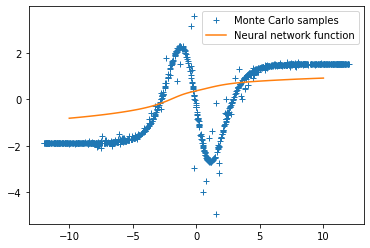

Patch 0: epoch 0 with loss 2.822875738143921


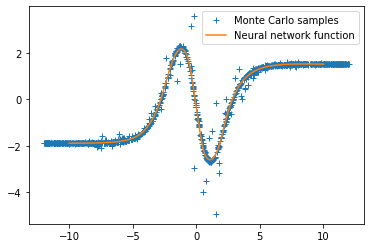

Patch 0: epoch 500 with loss 0.056063976138830185


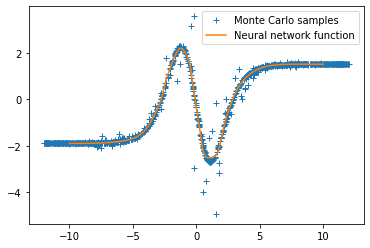

Patch 0: epoch 1000 with loss 0.054827574640512466


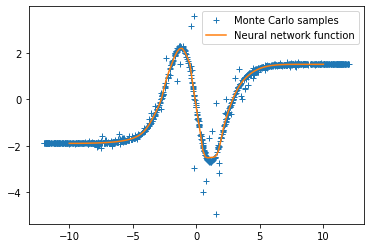

Patch 0: epoch 1500 with loss 0.054390642791986465


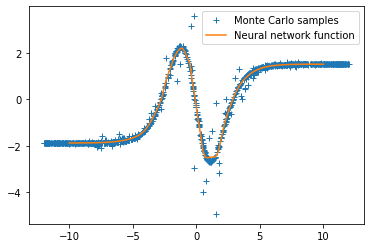

Patch 0: epoch 2000 with loss 0.05355348065495491


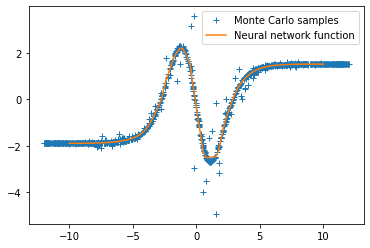

Patch 0: epoch 2500 with loss 0.05332368612289429


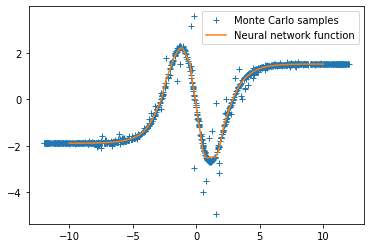

Patch 0: epoch 2999 with loss 0.05304889753460884
Patch 0: training of neural network with 3000 epochs take 9.65692663192749 seconds.
Time taken: 329 seconds; L1 error: 5.72E-02; L2 error: 1.04E-02; rel error: 6.97E-02.
fdb runtime: 1 seconds; total runtime: 329 seconds.




######## Summary for deep branching method
runtime:        329
fdb runtime:    1
total runtime:  329
mean L1 error:  5.72E-02
std L1 error:   0.00E+00
mean L2 error:  1.04E-02
std L2 error:   0.00E+00
mean rel error: 6.97E-02
std rel error:  0.00E+00


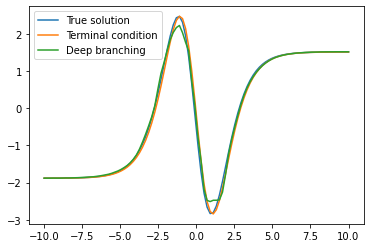

In [16]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Gradient of 1-dimensional Allen-Cahn

In [3]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return 0.25 * (1 - np.tanh(-x[0]/2 + 3*(T-t)/4)**2)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 10.239641666412354 seconds.


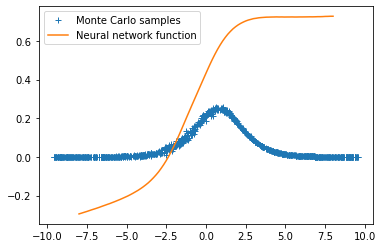

Patch 0: epoch 0 with loss 0.3921620547771454


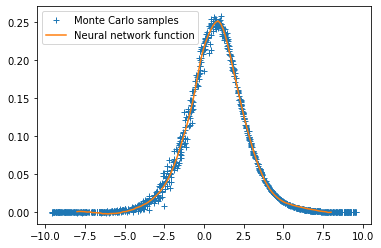

Patch 0: epoch 500 with loss 2.3328673705691472e-05


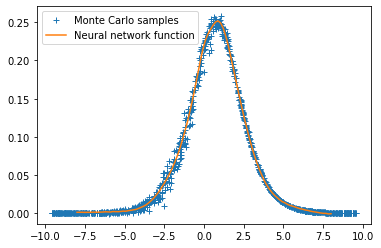

Patch 0: epoch 1000 with loss 2.2917927708476782e-05


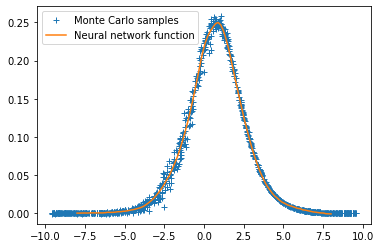

Patch 0: epoch 1500 with loss 2.197835965489503e-05


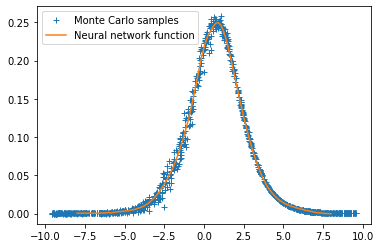

Patch 0: epoch 2000 with loss 2.1880918211536482e-05


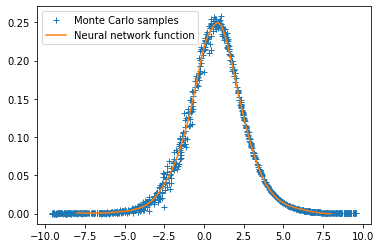

Patch 0: epoch 2500 with loss 2.1962900063954294e-05


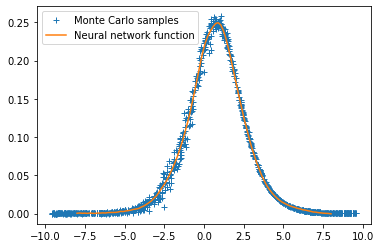

Patch 0: epoch 2999 with loss 2.1890014977543615e-05
Patch 0: training of neural network with 3000 epochs take 10.244534254074097 seconds.
Time taken: 23 seconds; L1 error: 9.34E-04; L2 error: 2.07E-06; rel error: 1.65E-01.
fdb runtime: 0 seconds; total runtime: 23 seconds.




######## Summary for deep branching method
runtime:        23
fdb runtime:    0
total runtime:  23
mean L1 error:  9.34E-04
std L1 error:   0.00E+00
mean L2 error:  2.07E-06
std L2 error:   0.00E+00
mean rel error: 1.65E-01
std rel error:  0.00E+00


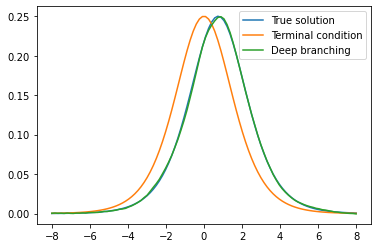

In [4]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn", code=[-2],
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

# 1-dimensional PDE

## Allen-Cahn

In [ ]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-x[0]/2 + 3*(T-t)/4)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 29 seconds; L1 error: 1.40E-03; L2 error: 5.07E-06; rel error: 3.03E-02.
fdb runtime: 0 seconds; total runtime: 29 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 62 seconds; L1 error: 1.04E-03; L2 error: 2.20E-06; rel error: 2.48E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 103 seconds; L1 error: 3.20E-03; L2 error: 1.47E-05; rel error: 3.08E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 29 seconds; L1 error: 1.42E-03; L2 error: 3.64E-06; rel error: 7.75E-02.
fdb runtime: 0 seconds; total runtime: 29 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 56 seconds; L1 error: 9.53E-04; L2 error: 1.42E-06; rel error: 8.78E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 101 seconds; L1 error: 3.87E-03; L2 error: 2.09E-05; rel error

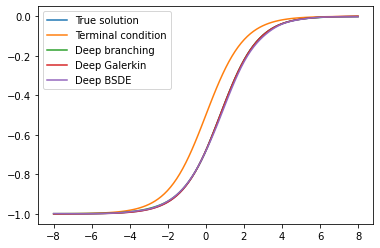

In [ ]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 22 seconds; L1 error: 1.40E-03; L2 error: 5.07E-06; rel error: 3.03E-02.
fdb runtime: 0 seconds; total runtime: 22 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 34 seconds; L1 error: 1.04E-03; L2 error: 2.20E-06; rel error: 2.48E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 45 seconds; L1 error: 5.56E-03; L2 error: 5.50E-05; rel error: 5.35E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 23 seconds; L1 error: 1.42E-03; L2 error: 3.64E-06; rel error: 7.75E-02.
fdb runtime: 0 seconds; total runtime: 23 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 34 seconds; L1 error: 9.53E-04; L2 error: 1.42E-06; rel error: 8.78E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 45 seconds; L1 error: 3.34E-03; L2 error: 1.91E-05; rel error: 

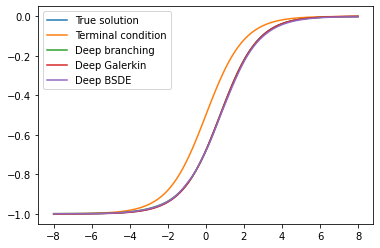

In [ ]:
# Performance comparison, old version of BSDE
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity

In [ ]:
alpha = 10

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return torch.exp(-y[0]) - 2 * torch.exp(-2 * y[0]) + alpha * y[1]

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return .5 * y[2] + torch.exp(-y[0]) - 2 * torch.exp(-2 * y[0]) + alpha * y[1]

def phi_example(x):
    return torch.log(1 + x[0] ** 2)

def exact_example(t, x, T):
    return np.log(1 + (x[0] + alpha * (T - t)) ** 2)

t_lo, x_lo, x_hi, n = 0., -4., 4., 1
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 44 seconds; L1 error: 9.38E-03; L2 error: 2.66E-04; rel error: 7.15E-01.
fdb runtime: 0 seconds; total runtime: 44 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 62 seconds; L1 error: 1.22E-02; L2 error: 2.19E-04; rel error: 6.64E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 101 seconds; L1 error: 1.36E-02; L2 error: 4.01E-04; rel error: 1.55E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 39 seconds; L1 error: 1.10E-02; L2 error: 3.45E-04; rel error: 6.63E-01.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 61 seconds; L1 error: 1.09E-02; L2 error: 2.29E-04; rel error: 9.53E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 102 seconds; L1 error: 1.10E-02; L2 error: 2.44E-04; rel error

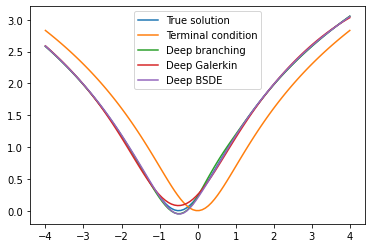

In [ ]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=30000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 38 seconds; L1 error: 9.38E-03; L2 error: 2.66E-04; rel error: 7.15E-01.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 43 seconds; L1 error: 1.22E-02; L2 error: 2.19E-04; rel error: 6.64E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 55 seconds; L1 error: 1.08E-02; L2 error: 2.40E-04; rel error: 1.01E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 34 seconds; L1 error: 1.10E-02; L2 error: 3.45E-04; rel error: 6.63E-01.
fdb runtime: 0 seconds; total runtime: 34 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 43 seconds; L1 error: 1.09E-02; L2 error: 2.29E-04; rel error: 9.53E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 55 seconds; L1 error: 9.70E-03; L2 error: 3.81E-04; rel error: 

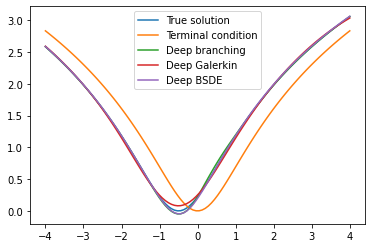

In [ ]:
# Performance comparison, old version of BSDE
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=30000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=1000, bsde_nb_time_intervals=5,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Cosine nonlinearity

In [ ]:
alpha = 10

# function definition
deriv_map = np.array([0, 1, 2, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> forth deriv
    """
    return -.5 * y[2] + alpha * y[1] + y[0] - (y[2] / 12) ** 2 + torch.cos(math.pi * y[3] / 24)

dgm_deriv_map = np.array([0, 1, 2, 4]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> forth deriv
    """
    return alpha * y[1] + y[0] - (y[2] / 12) ** 2 + torch.cos(math.pi * y[3] / 24)

def phi_example(x):
    return x[0]**4 + x[0]**3 - 36/47 * x[0]**2 - 24*36/47 * x[0] + 4 * (36/47)**2

def exact_example(t, x, T):
    xx = x[0] + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

t_lo, x_lo, x_hi, n = 0., -5., 5., 4
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .04
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 124 seconds; L1 error: 1.04E+01; L2 error: 3.24E+02; rel error: 3.21E-01.
fdb runtime: 1 seconds; total runtime: 125 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 2.90E+01; L2 error: 1.59E+03; rel error: 1.22E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 123 seconds; L1 error: 9.97E+00; L2 error: 3.50E+02; rel error: 3.16E-01.
fdb runtime: 0 seconds; total runtime: 123 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 1.55E+01; L2 error: 6.21E+02; rel error: 3.66E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 129 seconds; L1 error: 9.24E+00; L2 error: 3.55E+02; rel error: 2.35E-01.
fdb runtime: 0 seconds; total runtime: 130 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time 

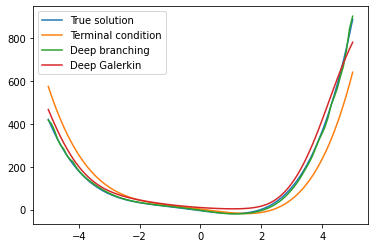

In [ ]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0], 
                    # disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, dgm_lr=1e-2, fname="cosine",
                    branch_nb_states=1000, branch_nb_path_per_state=2500,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Log nonlinearity

In [ ]:
alpha = 10

# function definition
deriv_map = np.array([1, 2, 3]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> first deriv
    idx 1 -> second deriv
    idx 2 -> third deriv
    """
    return -.5 * y[1] + alpha * y[0] + torch.log(y[1]**2 + y[2]**2)

dgm_deriv_map = np.array([1, 2, 3]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> first deriv
    idx 1 -> second deriv
    idx 2 -> third deriv
    """
    return alpha * y[0] + torch.log(y[1]**2 + y[2]**2)

def phi_example(x):
    return torch.cos(x[0])

def exact_example(t, x, T):
    return np.cos(x[0] + alpha * (T-t))

t_lo, x_lo, x_hi, n = 0., -3., 3., 3
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .02
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 80 seconds; L1 error: 4.29E-03; L2 error: 2.93E-05; rel error: 2.13E-02.
fdb runtime: 0 seconds; total runtime: 80 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 83 seconds; L1 error: 1.27E-01; L2 error: 2.12E-02; rel error: 4.56E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 78 seconds; L1 error: 5.29E-03; L2 error: 3.98E-05; rel error: 1.70E-02.
fdb runtime: 0 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 83 seconds; L1 error: 6.01E-02; L2 error: 4.72E-03; rel error: 2.53E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 78 seconds; L1 error: 6.01E-03; L2 error: 6.21E-05; rel error: 2.88E-02.
fdb runtime: 0 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 8

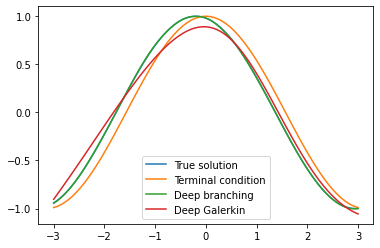

In [ ]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0], 
                    # disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="log",
                    branch_nb_states=1000, branch_nb_path_per_state=6000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=1000, bsde_nb_time_intervals=5,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Merton problem

In [ ]:
mu = .03
sigma = .1
gamma = .5
rho = .01

# TODO: how to deal with negative x and y[1] properly???

# function definition
deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -.5 * y[2] - (mu * y[1])**2 / (2 * sigma**2 * y[2]) + gamma * y[1].abs()**(1 - 1/gamma) / (1 - gamma) - rho * y[0]

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -(mu * y[1])**2 / (2 * sigma**2 * y[2]) + gamma * y[1].abs()**(1 - 1/gamma) / (1 - gamma) - rho * y[0]

def phi_example(x):
    return x[0].abs() ** (1 - gamma) / (1 - gamma)

def exact_example(t, x, T):
    nu = (2 * sigma**2 * gamma * rho - (1 - gamma) * mu**2) / (2 * sigma**2 * gamma**2)
    return x[0]**(1 - gamma) * (1 + (nu-1) * math.exp(-nu * (T - t)))**gamma / (nu**gamma * (1 - gamma))

t_lo, x_lo, x_hi, n = 0., 100., 200., 2
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .1
true = exact_example(t_lo, grid_d_dim, T).real
terminal = exact_example(T, grid_d_dim, T).real

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 55 seconds; L1 error: 9.34E-03; L2 error: 1.70E-04; rel error: 3.64E-04.
fdb runtime: 0 seconds; total runtime: 55 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 186 seconds; L1 error: 1.63E+00; L2 error: 2.84E+00; rel error: 6.27E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 56 seconds; L1 error: 9.08E-03; L2 error: 1.55E-04; rel error: 3.46E-04.
fdb runtime: 0 seconds; total runtime: 56 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 184 seconds; L1 error: 1.35E+00; L2 error: 1.83E+00; rel error: 5.29E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 56 seconds; L1 error: 7.53E-03; L2 error: 1.06E-04; rel error: 2.93E-04.
fdb runtime: 0 seconds; total runtime: 56 seconds.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 184 seconds

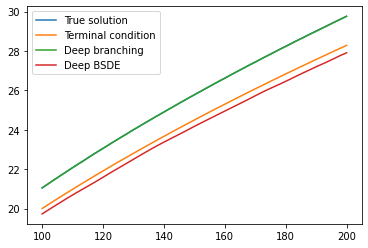

In [31]:
# with 2BSDE...
#
# Performance comparison, deep branching seems to have gradient problem, hence we use relu activation function
# Also, it doesn't work for DGM method because of possible zero second derivatives, so we disable it
#
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[2],
                    disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="merton",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000, branch_activation="relu",
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4, y_lo=0, y_hi=100,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 47 seconds; L1 error: 9.34E-03; L2 error: 1.70E-04; rel error: 3.64E-04.
fdb runtime: 0 seconds; total runtime: 47 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 48 seconds; L1 error: 9.08E-03; L2 error: 1.55E-04; rel error: 3.46E-04.
fdb runtime: 0 seconds; total runtime: 48 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 48 seconds; L1 error: 7.53E-03; L2 error: 1.06E-04; rel error: 2.93E-04.
fdb runtime: 0 seconds; total runtime: 48 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 45 seconds; L1 error: 8.32E-03; L2 error: 1.23E-04; rel error: 3.19E-04.
fdb runtime: 0 seconds; total runtime: 45 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 47 seconds; L1 error: 8.78E-03; L2 error: 1.37E-04; rel error: 3.41E-04.
fdb runtime: 0 seconds;

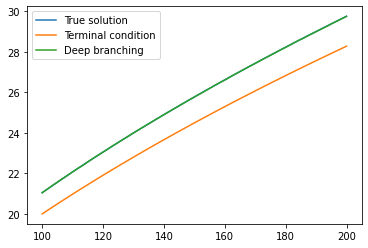

In [ ]:
# old version without 2BSDE
#
# Performance comparison, deep branching seems to have gradient problem, hence we use relu activation function
# Also, it doesn't work for DGM method because of possible zero second derivatives, so we disable it
#
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[2],
                    disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="merton",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000, branch_activation="relu",
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 2 - 1 out of 1 times
Patch 0: generation of samples take 39.00997829437256 seconds.


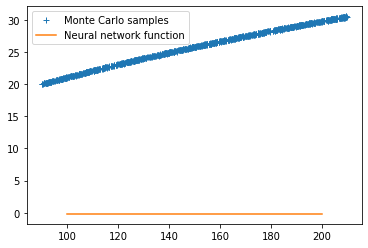

Patch 0: epoch 0 with loss 668.4487915039062


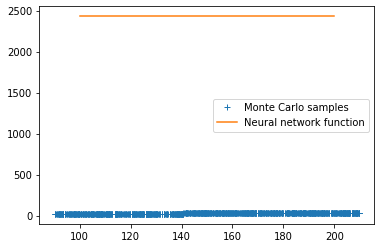

Patch 0: epoch 500 with loss 9.09670352935791


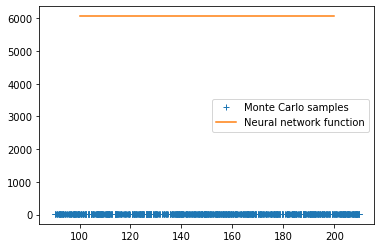

Patch 0: epoch 1000 with loss 9.096700668334961


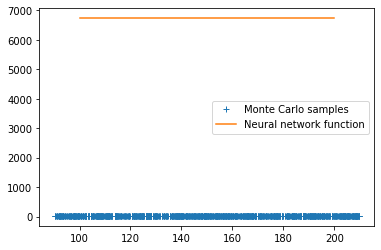

Patch 0: epoch 1500 with loss 9.096701622009277


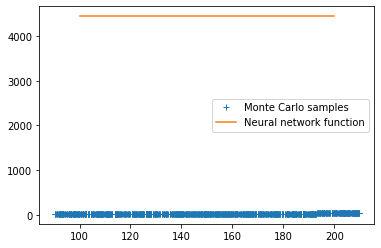

Patch 0: epoch 2000 with loss 9.096701622009277


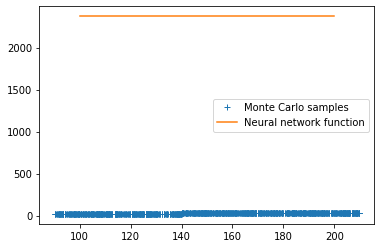

Patch 0: epoch 2500 with loss 9.096701622009277


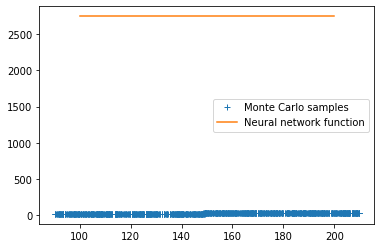

Patch 0: epoch 2999 with loss 9.096701622009277
Patch 0: training of neural network with 3000 epochs take 12.270853042602539 seconds.
Time taken: 51 seconds; L1 error: 2.72E+03; L2 error: 7.39E+06; rel error: 1.07E+02.
fdb runtime: 0 seconds; total runtime: 51 seconds.




######## Summary for deep branching method
runtime:        51
fdb runtime:    0
total runtime:  51
mean L1 error:  2.72E+03
std L1 error:   0.00E+00
mean L2 error:  7.39E+06
std L2 error:   0.00E+00
mean rel error: 1.07E+02
std rel error:  0.00E+00


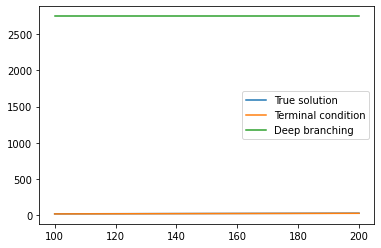

In [ ]:
# Performance comparison, seems to have gradient problem when using tanh activation
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, seeds=[2],
                    disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000,
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000, # branch_activation="relu",
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

# d-dimensional PDE

## Allen-Cahn

In [ ]:
fixed_dim, dim = 0, 5

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 107 seconds; L1 error: 3.59E-03; L2 error: 2.16E-05; rel error: 6.68E-03.
fdb runtime: 0 seconds; total runtime: 107 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 134 seconds; L1 error: 5.82E-03; L2 error: 3.89E-05; rel error: 2.71E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 170 seconds; L1 error: 4.86E-03; L2 error: 3.47E-05; rel error: 1.59E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 116 seconds; L1 error: 3.62E-03; L2 error: 2.03E-05; rel error: 6.84E-03.
fdb runtime: 0 seconds; total runtime: 116 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 133 seconds; L1 error: 3.27E-03; L2 error: 2.38E-05; rel error: 2.30E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 170 seconds; L1 error: 4.71E-03; L2 error: 3.91E-05; rel

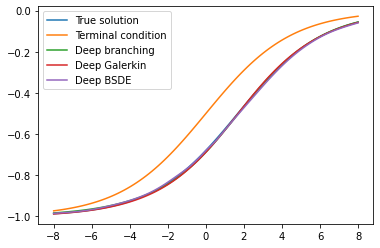

In [ ]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 101 seconds; L1 error: 3.59E-03; L2 error: 2.16E-05; rel error: 6.68E-03.
fdb runtime: 0 seconds; total runtime: 101 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 112 seconds; L1 error: 5.82E-03; L2 error: 3.89E-05; rel error: 2.71E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 118 seconds; L1 error: 3.57E-03; L2 error: 1.73E-05; rel error: 1.15E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 110 seconds; L1 error: 3.62E-03; L2 error: 2.03E-05; rel error: 6.84E-03.
fdb runtime: 0 seconds; total runtime: 110 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 112 seconds; L1 error: 3.27E-03; L2 error: 2.38E-05; rel error: 2.30E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 118 seconds; L1 error: 3.83E-03; L2 error: 2.04E-05; rel

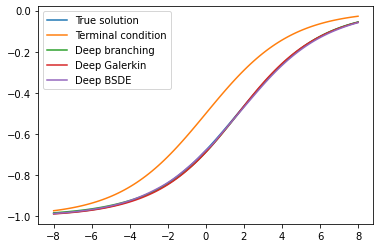

In [ ]:
 # Performance comparison, old version of BSDE
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity

In [ ]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0         -> no deriv
    idx 1 to d    -> first deriv
    idx 1+d to 2d -> second deriv
    """
    return .5 * y[(dim+1):].sum(dim=0) + alpha/dim*y[1:(dim+1)].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

t_lo, x_lo, x_hi, n = 0., -4., 4., 1
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 148 seconds; L1 error: 3.09E-02; L2 error: 2.77E-03; rel error: 1.03E+00.
fdb runtime: 0 seconds; total runtime: 148 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 187 seconds; L1 error: 2.36E+00; L2 error: 6.98E+00; rel error: 9.18E+01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 171 seconds; L1 error: 1.82E-02; L2 error: 1.33E-03; rel error: 2.84E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 161 seconds; L1 error: 2.97E-02; L2 error: 3.28E-03; rel error: 5.13E+00.
fdb runtime: 0 seconds; total runtime: 162 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 187 seconds; L1 error: 1.88E+00; L2 error: 4.98E+00; rel error: 8.29E+01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 171 seconds; L1 error: 1.92E-02; L2 error: 1.37E-03; rel

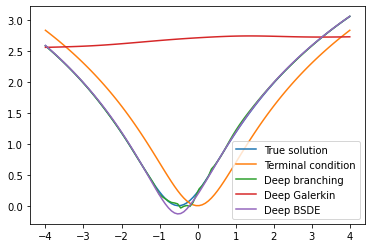

In [ ]:
# corrected bn_layer for deep_bsde method
#
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_galerkin=True, disable_bsde=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=3000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 140 seconds; L1 error: 3.09E-02; L2 error: 2.77E-03; rel error: 1.03E+00.
fdb runtime: 0 seconds; total runtime: 141 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 154 seconds; L1 error: 2.36E+00; L2 error: 6.98E+00; rel error: 9.18E+01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 119 seconds; L1 error: 1.42E-02; L2 error: 7.47E-04; rel error: 2.12E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 154 seconds; L1 error: 2.97E-02; L2 error: 3.28E-03; rel error: 5.13E+00.
fdb runtime: 0 seconds; total runtime: 154 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 154 seconds; L1 error: 1.88E+00; L2 error: 4.98E+00; rel error: 8.29E+01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 119 seconds; L1 error: 1.40E-02; L2 error: 7.79E-04; rel

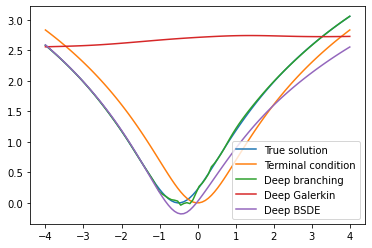

In [ ]:
 # Performance comparison, old version of BSDE
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_galerkin=True, disable_bsde=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=3000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=100000, bsde_nb_time_intervals=5,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Cosine nonlinearity

In [ ]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim), 4 * np.identity(dim)), axis=0).astype(int)
def f_example(y):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim
    

dgm_deriv_map = deriv_map
def dgm_f_example(y):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim

def phi_example(x):
    xx = x.sum(dim=0)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

def exact_example(t, x, T):
    xx = x.sum(axis=0) + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

t_lo, x_lo, x_hi, n = 0., -5., 5., 4
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .04
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 100 seconds; L1 error: 7.33E+00; L2 error: 1.39E+02; rel error: 1.63E-01.
fdb runtime: 44 seconds; total runtime: 143 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 670 seconds; L1 error: 2.59E+02; L2 error: 7.88E+04; rel error: 3.10E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 323 seconds; L1 error: 1.00E+01; L2 error: 3.02E+02; rel error: 1.16E-01.
fdb runtime: 133 seconds; total runtime: 456 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 669 seconds; L1 error: 2.57E+02; L2 error: 7.77E+04; rel error: 3.08E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 83 seconds; L1 error: 1.08E+01; L2 error: 4.61E+02; rel error: 1.60E-01.
fdb runtime: 60 seconds; total runtime: 143 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Ti

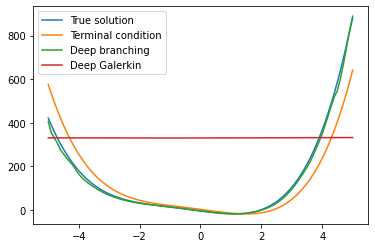

In [ ]:
 # Performance comparison
 #
 # choosing one percentile for removal of outlier in the case of branch_nb_path_per_state=50
 # does not completely remove any outlier
 # we have to choose three percentile in this case
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0],
                    # disable_galerkin=True, verbose=True, debug_mode=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="cosine",
                    branch_nb_states=1000, branch_nb_path_per_state=50,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000, outlier_percentile=3,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Log nonlinearity

In [ ]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((1 * np.identity(dim), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return -.5 * y[dim:(2*dim)].sum(dim=0) + alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)
    

dgm_deriv_map = deriv_map
def dgm_f_example(y):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)

def phi_example(x):
    return torch.cos(x.sum(dim=0))

def exact_example(t, x, T):
    return np.cos(x.sum(axis=0) + alpha * (T-t))

t_lo, x_lo, x_hi, n = 0., -3., 3., 3
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .02
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 200 seconds; L1 error: 2.76E-02; L2 error: 1.66E-03; rel error: 1.39E-01.
fdb runtime: 58 seconds; total runtime: 258 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 369 seconds; L1 error: 6.41E-01; L2 error: 5.21E-01; rel error: 1.32E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 100 seconds; L1 error: 2.01E-02; L2 error: 6.38E-04; rel error: 6.80E-02.
fdb runtime: 45 seconds; total runtime: 145 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 369 seconds; L1 error: 6.40E-01; L2 error: 5.22E-01; rel error: 1.36E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 182 seconds; L1 error: 2.83E-02; L2 error: 2.90E-03; rel error: 1.38E-01.
fdb runtime: 54 seconds; total runtime: 236 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Ti

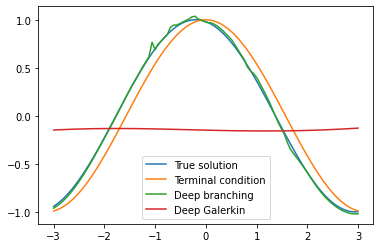

In [ ]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[7],
                    # disable_galerkin=True, verbose=True, debug_mode=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="log",
                    branch_nb_states=1000, branch_nb_path_per_state=200,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)